# **Final Resturant Project - Justin Do & Defne Sener**

# **What is the optimal location in NYC and cuisine type to open a new restaurant seeking longevity?**

---

## Steps we need to take to solve our goal:
### **For longevity, we need to find an area with limited competition**
- [x] Connecting to our database and set up our base query for a Base Pandas Dataframe
- [x] Clean our data by providing grades where score values are not Null, clear duplicate dba (restaurant names) and irrelevant testing data.
- [x] Clear Duplicates from our Base Dataframe. Set a neighborhood column for each zipcode available in our CSV file and provide grades based on our scores.
- [x] Find the cuisine with the lowest amount of competition then figure out how many restaurants are in each of those lower cuisine groups
- [x] Split our Dataframes into two sub DF; A grade & BC grades. It's important to select 'critical' values in critical flags for B&C df because we want to find dirty restaurants (based on their recent inspection) to take over. Once we split, we need to find the cuisine type where there are three or less restaurant for our A grade restaurants. This brings us a step closer to selecting a B&C-grade restaurant area to take over.
- [x] Combine our sub Dataframes where our B&C group has available cuisine types with our filtered A-grade group (cuisine type <= 3). This will allow us to filter the cuisine types that both dataframes **DON'T** have in common. Once we finish, we should have a dataframe of A,B & C grades where B&C cuisine types are present in A df and there are less than 3 restaurants in A (for each cuisine types per borough).
- [x] Graph our combined DF to show how many restaurants are in each cuisine type for each borough 
- [x] Split our combined df into two df where one is A-Grade and the other is B&C-Grade. These two df should **NOT** be the same as our other groups because they:
    1. Have the cuisine type that has less than three A-Grade resturant with it
    2. Have the same cuisine types as each other (B&C cuisine should be in A cuisine)
- [x] Focus on **High Scores (Low Grades)** and **Critical Flags** where it's **Critical** meaning the resturant is quite dirty so we target the audiences that prefer cleaniness 
- [x] Build the A-Grade-Critical DataFrame based off the the max scores in our B&C group. This will help us find the cuisine type with the highest score in B&C-Grade df. 
- [x] Find the smallest amount of resturants in A-Grade-Critical DF with the highest B&C scores and their violation description for us to learn from their mistakes. To conclude, we'd have three cuisine type in a certain borough where the cuisine type have high B&C scores. 
- [x] Graph the max B&C scores for our chosen boroughs and the Number of A-grade Resturants. We want to find a cuisine type with a high B&C scores with a low number of A-grade resturants.

---

### Connecting to the Restaurant and Violation Database and Importing our modules 

In [1]:
import pandas as pd
import pyodbc
import os
import matplotlib.pyplot as plt
import matplotlib
from sql_pass import *

# NOTE: Chance password and username to your information to run the code
password = sql_pass
username = 'justindo47'
default_db = "Fall_2022"
server = "localhost"

cnxn = pyodbc.connect(
    "DRIVER={ODBC Driver 17 for SQL Server};SERVER=%s;DATABASE=%s;UID=%s;PWD=%s;Encrypt=no;TrustServerCertificate=yes" %
    (server, default_db, username, password)
)

sql_query = pd.read_sql("""
        SELECT dba,
               boro,
               zipcode,
               cuisine_description,
               score,
               grade,
               critical_flag,
               violation_description,
               inspection_date,
               record_date,
               datediff(year, inspection_date, record_date) as record_inspection_diff
        FROM restaurant_data as rd 
            LEFT JOIN violation_data as vd
                ON rd.camis = vd.camis
        WHERE dba NOT LIKE 'Test%' AND score IS NOT NULL
        """, con=cnxn)
print(cnxn)    # a working connection means we're ready to start

### Creating our base Dataframe seeking for longevity and removing duplicate values

In [2]:
# Creating our base dataframe and get our zipcode dataframe 
rest_viol_df = pd.DataFrame(sql_query)
zipcodes_df = pd.read_csv('nyc-zip-codes.csv')
zipcodes_df.drop('Borough', axis=1, inplace=True)
zipcodes_df.columns = ['neighborhood', 'zipcode']
zipcodes_df['zipcode'] = zipcodes_df['zipcode'].astype(str)
rest_viol_df = pd.merge(rest_viol_df, zipcodes_df, on='zipcode')

# Since we are focused on longevity, we need to look for resturants with high record_inspection_diff
# 5+ record inspection difference (record_date - inspection) would mean the resturants lived longer than 5 years (generational)
rest_viol_df = rest_viol_df.loc[rest_viol_df['record_inspection_diff'] >= 5]

# now we need to provide grades to our present score values 
rest_viol_df.loc[(rest_viol_df['grade'].isnull()) & (rest_viol_df['score'] <= 13), 'grade'] = 'A'
rest_viol_df.loc[
    (rest_viol_df['grade'].isnull()) & (rest_viol_df['score'] > 13) & (rest_viol_df['score'] <= 27), 'grade'] = 'B'
rest_viol_df.loc[(rest_viol_df['grade'].isnull()) & (rest_viol_df['score'] >= 28), 'grade'] = 'C'
# sort by inspect date (desc high-low) most recent inspection (bc drop_dup will take the FIRST inspection it sees from dba)
rest_viol_df.sort_values(by=['inspection_date', 'score'], ascending=[0, 0], inplace=True)
rest_viol_df

,dba,boro,zipcode,cuisine_description,score,grade,critical_flag,violation_description,inspection_date,record_date,record_inspection_diff,neighborhood
64760,FLAVAS INTERNATIONAL GRILL,Bronx,10451,Caribbean,44,C,Not Critical,Non-food contact surface improperly constructe...,2017-12-29,2022-08-27 06:00:12,5,High Bridge and Morrisania
64776,FLAVAS INTERNATIONAL GRILL,Bronx,10451,Caribbean,44,C,Not Critical,Non-food contact surface improperly constructe...,2017-12-29,2022-08-27 06:00:12,5,High Bridge and Morrisania
64804,FLAVAS INTERNATIONAL GRILL,Bronx,10451,Caribbean,44,C,Not Critical,Non-food contact surface improperly constructe...,2017-12-29,2022-08-27 06:00:12,5,High Bridge and Morrisania
64901,FLAVAS INTERNATIONAL GRILL,Bronx,10451,Caribbean,44,C,Not Critical,Facility not vermin proof. Harborage or condit...,2017-12-29,2022-08-27 06:00:12,5,High Bridge and Morrisania
64935,FLAVAS INTERNATIONAL GRILL,Bronx,10451,Caribbean,44,C,Critical,Filth flies or food/refuse/sewage-associated (...,2017-12-29,2022-08-27 06:00:12,5,High Bridge and Morrisania
...,...,...,...,...,...,...,...,...,...,...,...,...
42427,ESCOLAS,Queens,11106,Latin American,13,A,Not Critical,Facility not vermin proof. Harborage or condit...,2015-07-08,2022-08-27 06:00:12,7,Northwest Queens
42447,ESCOLAS,Queens,11106,Latin American,13,A,Critical,Filth flies or food/refuse/sewage-associated (...,2015-07-08,2022-08-27 06:00:12,7,Northwest Queens
41812,ESCOLAS,Queens,11106,Latin American,10,A,Critical,Evidence of mice or live mice present in facil...,2015-06-25,2022-08-27 06:00:12,7,Northwest Queens
42032,ESCOLAS,Queens,11106,Latin American,10,A,Not Critical,Facility not vermin proof. Harborage or condit...,2015-06-25,2022-08-27 06:00:12,7,Northwest Queens


In [3]:
# we need to remove duplicate values in our dataframe 
#.loc[rest_viol_df['critical_flag'] != 'Critical']
rest_viol_df = rest_viol_df.drop_duplicates(subset=['dba'])
rest_viol_df.head()

,dba,boro,zipcode,cuisine_description,score,grade,critical_flag,violation_description,inspection_date,record_date,record_inspection_diff,neighborhood
64760,FLAVAS INTERNATIONAL GRILL,Bronx,10451,Caribbean,44,C,Not Critical,Non-food contact surface improperly constructe...,2017-12-29,2022-08-27 06:00:12,5,High Bridge and Morrisania
154666,LA RUBIA RESTAURANT,Manhattan,10031,Latin American,20,B,Critical,Hot food item not held at or above 140º F.,2017-12-29,2022-08-27 06:00:12,5,Inwood and Washington Heights
118655,L'UNIQUE BAR & RESTAURANT,Brooklyn,11226,Caribbean,13,A,Critical,Filth flies or food/refuse/sewage-associated (...,2017-12-29,2022-08-27 06:00:12,5,Flatbush
227347,HEALTHY EATERS JAMAICAN RESTAURANT,Queens,11412,Caribbean,7,A,Not Critical,Pesticide use not in accordance with label or ...,2017-12-29,2022-08-27 06:00:12,5,Jamaica
60820,YVES,Manhattan,10013,American,4,A,Not Critical,Non-food contact surface improperly constructe...,2017-12-29,2022-08-27 06:00:12,5,Greenwich Village and Soho


### Create our sub groups of A & BC grades and find the least amount of restaurants in each cuisine type

In [4]:
# start to group them by boro and cuisine_description to count the amount of restaurants then filter
cuisine_groups = rest_viol_df.groupby(['boro', 'cuisine_description']).count()
less_cuisine_groups = cuisine_groups.loc[cuisine_groups['dba'] <= 10]['dba']    # cuisine types that have less than 10 restaurants
print(less_cuisine_groups)

boro           cuisine_description     
Bronx          African                     5
               Asian/Asian Fusion          1
               Bakery Products/Desserts    5
               Barbecue                    1
               Bottled Beverages           1
                                          ..
Staten Island  Pizza                       9
               Polish                      2
               Russian                     1
               Soul Food                   1
               Spanish                     1
Name: dba, Length: 168, dtype: int64


In [5]:
# Knowing the cuisines that have less than 10 restaurants, let's create a dataframe with these cuisines 
less_cuisine_df = pd.DataFrame()
for boro, cuisine_type in less_cuisine_groups.index:
    temp_df = rest_viol_df.loc[(rest_viol_df['boro'] == boro)&(rest_viol_df['cuisine_description'] == cuisine_type)]
    # concat is not an in place function so lets update of df
    less_cuisine_df = pd.concat([less_cuisine_df, temp_df])
    
less_cuisine_df.head()

,dba,boro,zipcode,cuisine_description,score,grade,critical_flag,violation_description,inspection_date,record_date,record_inspection_diff,neighborhood
148634,PAPA YE RESTAURANT,Bronx,10456,African,20,B,Critical,Food not protected from potential source of co...,2017-12-28,2022-08-27 06:00:12,5,High Bridge and Morrisania
117557,MAMA G AFRICAN KITCHEN,Bronx,10467,African,10,A,Not Critical,Pesticide use not in accordance with label or ...,2017-12-05,2022-08-27 06:00:12,5,Bronx Park and Fordham
117365,BRAVO AFRICAN RESTAURANT 2,Bronx,10467,African,7,A,Not Critical,Mechanical or natural ventilation system not p...,2017-10-18,2022-08-27 06:00:12,5,Bronx Park and Fordham
40263,SOMBA VILLAGE (BABOON CAFE),Bronx,10460,African,5,A,Critical,Food not protected from potential source of co...,2017-06-14,2022-08-27 06:00:12,5,Central Bronx
126991,GALAGALA NY RESTAURANT,Bronx,10453,African,10,A,Critical,Evidence of mice or live mice present in facil...,2016-12-28,2022-08-27 06:00:12,6,Central Bronx


### Split our less cuisine dataframe into two sub dataframes to compare A-grade restaurants with B&C-grade restaurants

In [6]:
# Working with A-grade 
a_less_cuisine_df = less_cuisine_df.loc[less_cuisine_df['grade'] == 'A']
a_viol_info_group = a_less_cuisine_df.groupby(['boro', 'cuisine_description']).count()

# limit down the cuisine choice where there are 3 or fewer resturants in this cuisine type for our A-grade restaurants 
a_viol_info_group = a_viol_info_group.loc[a_viol_info_group['dba'] <= 3]['dba']
a_viol_info_group    # all these cuisine types in each boro should be less than or equal to three restaurant 

boro           cuisine_description
Bronx          Bottled Beverages      1
               Chicken                2
               Frozen Desserts        3
               Greek                  1
               Hamburgers             2
                                     ..
Staten Island  Middle Eastern         2
               Other                  1
               Polish                 2
               Russian                1
               Soul Food              1
Name: dba, Length: 122, dtype: int64

In [7]:
# Working with B&C-grade (we want to make sure these bc group have critical flags because we want to find bad restaurants in this df)
bc_less_cuisine_df = less_cuisine_df.loc[(less_cuisine_df['grade'] == 'B') | (less_cuisine_df['grade'] == 'C')].loc[(less_cuisine_df['critical_flag'] == 'Critical')].sort_values(by='grade', ascending=1)
bc_viol_info_group = bc_less_cuisine_df.groupby(['boro', 'cuisine_description']).count()
bc_viol_info_group['dba']

boro           cuisine_description     
Bronx          African                     1
               Bakery Products/Desserts    1
               Barbecue                    1
               Chicken                     2
               Irish                       1
               Thai                        1
Brooklyn       African                     1
               Asian/Asian Fusion          1
               Bottled Beverages           1
               Brazilian                   1
               Chinese                     2
               Coffee/Tea                  1
               German                      1
               Latin American              1
               Mediterranean               1
               Polish                      1
               Russian                     2
               Tapas                       2
               Vegan                       1
Manhattan      African                     2
               Bottled Beverages           2
               

### Combining subdataframes to get the cuisine types that are in common 

In [8]:
abc_viol_info_df = pd.DataFrame() 
for boro, cuisine in bc_viol_info_group.index:
    if (boro,cuisine) in a_viol_info_group.index:
        a_temp_df = rest_viol_df.loc[(rest_viol_df['boro'] == boro) & (rest_viol_df['cuisine_description'] == cuisine) & (rest_viol_df['grade'] == 'A')]
        b_temp_df = rest_viol_df.loc[(rest_viol_df['boro'] == boro) & (rest_viol_df['cuisine_description'] == cuisine)].loc[(rest_viol_df['grade'] == 'B') | (rest_viol_df['grade'] == 'C')].loc[(less_cuisine_df['critical_flag'] == 'Critical')]
        abc_viol_info_df = pd.concat([abc_viol_info_df, a_temp_df, b_temp_df])

# after we combined our subdataframes, we create a group focusing on grades
abc_viol_info_group = abc_viol_info_df.groupby(['boro', 'cuisine_description','grade'])['dba'].count()
abc_viol_info_group

boro           cuisine_description  grade
Bronx          Chicken              A        2
                                    B        2
               Irish                A        1
                                    C        1
Brooklyn       African              A        1
                                    B        1
               Asian/Asian Fusion   A        3
                                    C        1
               German               A        2
                                    B        1
               Latin American       A        3
                                    B        1
               Mediterranean        A        1
                                    C        1
               Polish               A        1
                                    C        1
               Tapas                A        1
                                    B        1
                                    C        1
Manhattan      African              A        3
                  

### Graphing our A & BC Dataframe to see the number of restaurants for each cuisine type

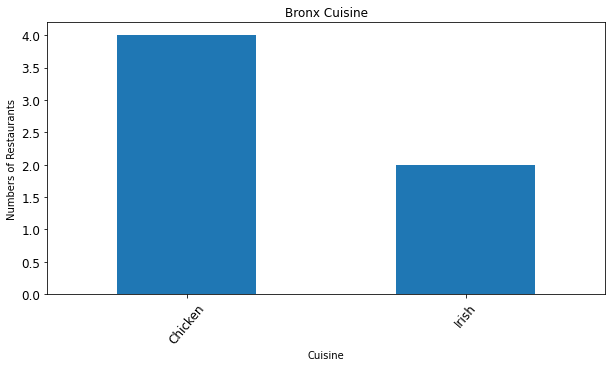

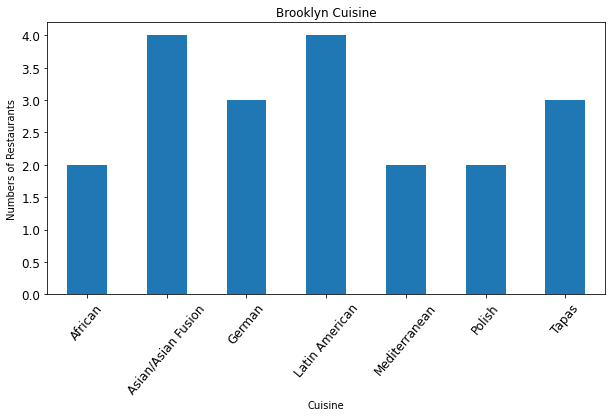

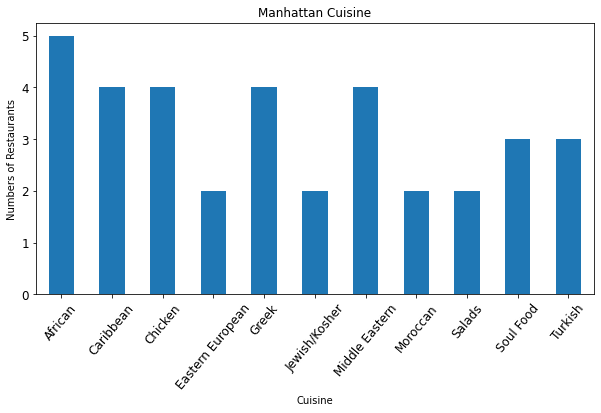

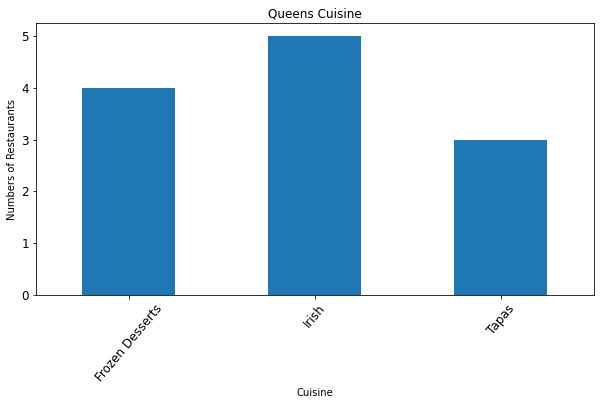

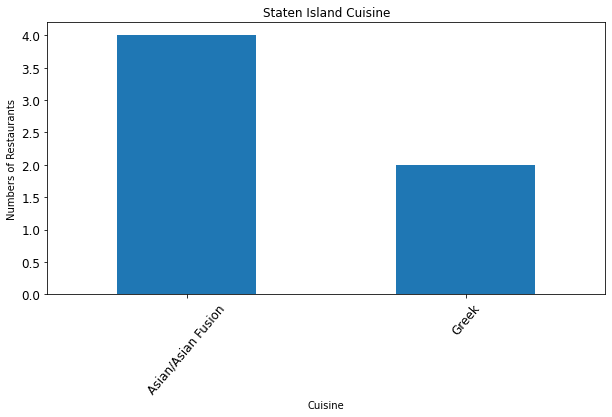

In [9]:
list_of_boro = abc_viol_info_df.boro.unique()
for boro in list_of_boro:
    # we need to find all the restaurant in our filtered less_cuisine_df
    boro_df = abc_viol_info_df.loc[abc_viol_info_df['boro'] == boro]
    # then group it and find the count to graph
    boro_group = boro_df.groupby(['boro', 'cuisine_description']).count()['dba']
    boro_cuisine_indexes = []
    for boro_name, cuisine_description in boro_group.index:
        boro_cuisine_indexes.append(cuisine_description)
    boro_group.index = boro_cuisine_indexes
    boro_group.plot(kind='bar', title=f"{boro} Cuisine", rot=50,
                    fontsize=12, figsize=(10, 5), xlabel='Cuisine',
                    ylabel='Numbers of Restaurants')
    plt.show()

---

## Recap 

### **Main Idea:** Since we are focused on longevity, we want to pick a location where competition is low
- *Built a base dataframe* where score isn't null (since we are basing our decisions off grade), no present testing data (e.g dba = 'Test..') and a record inspection difference to give us a timeframe of how long the restaurant lasted
- *Cleared duplicated restaurant names* to uniquely count the number of restaurants per cuisine type in each borough  
- *Found the amount of resturants in the lower cuisine groups* by grouping our base df and filtering for cuisine types that have less than **10** restaurants 
- *Created a dataframe with those cuisine types* to have a df with cuisine types that have less than 10 resturants
- *Split our less cuisine df into two sub df* where one df has A-Grades only and the other has B&C-Grades. This will allow us to compare our two df and help us figure out a location near B&C-graded resturants to take over that area.
- *Filtered our A-grade group* to find cuisine types that have less than three restaurants. The reason why **ONLY** do this with the A-Grade df is because, we want to stay away from the already successful restaurants. B&C-grade df doesn't need this filter because we are assuming that (taking critical flags into account) the restaurants aren't the best which gives us an idea of where to position our place.
- *Combined the B&C group and our **filtered** A group into a dataframe* based on similar cuisine types by accessing matching their indexes. This is quite important because we want to make sure the area we choose has mininal to no A-grade competition. Combining our groups into a df will shift our focus on **the number of resturants** in each cuisine types to **grades**.
- *Graphed our ABC-Grade Df* so we could visually see the number of restaurants for each cuisine type

---

## Split our combined dataframe and focusing on critical values

In [10]:
# Let's focus on BC-Grade first. We need to make sure we find vlaues where the critical flag is Critical (since we want to find the worse restaurants in this df through their recent inspection)
split_bc_viol_info = abc_viol_info_df.loc[(abc_viol_info_df['grade'] == 'B') | (abc_viol_info_df['grade'] == 'C')].sort_values(by=['boro','score'], ascending=[0,0]) # we'll use this to find the restaurant location
critical_split_bc_viol_group = split_bc_viol_info.groupby(['boro', 'cuisine_description']).score.aggregate('max')
critical_split_bc_viol_group    # we'll use this group to plot our max points after getting our final selections

boro           cuisine_description
Bronx          Chicken                19
               Irish                  42
Brooklyn       African                18
               Asian/Asian Fusion     28
               German                 17
               Latin American         24
               Mediterranean          35
               Polish                 30
               Tapas                  42
Manhattan      African                25
               Caribbean              28
               Chicken                22
               Eastern European       25
               Greek                  23
               Jewish/Kosher          36
               Middle Eastern         21
               Moroccan               39
               Salads                 19
               Soul Food              22
               Turkish                18
Queens         Frozen Desserts        22
               Irish                  25
               Tapas                  18
Staten Island  Asian/A

In [11]:
# Now let's build our A-Grade df 
split_a_viol_info = abc_viol_info_df.loc[(abc_viol_info_df['grade'] == 'A')].sort_values(by=['boro', 'cuisine_description'], ascending=[0,0])
critical_split_a_viol_df = pd.DataFrame()
for boro, cuisine in critical_split_bc_viol_group.index:
    # again we only need information where our cuisines type match because we want to find the cuisine type  with the highest score in B&C-Grade df and have a small amount of resturants in A-Grade
    df = split_a_viol_info.loc[(split_a_viol_info['boro'] == boro) & (split_a_viol_info['cuisine_description'] == cuisine)]
    critical_split_a_viol_df = pd.concat([critical_split_a_viol_df, df])
critical_split_a_viol_df.head()

,dba,boro,zipcode,cuisine_description,score,grade,critical_flag,violation_description,inspection_date,record_date,record_inspection_diff,neighborhood
149250,KENNEDY FRIED CHICKEN,Bronx,10456,Chicken,12,A,Critical,Hot food item not held at or above 140º F.,2017-07-18,2022-08-27 06:00:12,5,High Bridge and Morrisania
99184,Texas Chicken and Burger,Bronx,10468,Chicken,11,A,Critical,Evidence of mice or live mice present in facil...,2017-04-20,2022-08-27 06:00:12,5,Bronx Park and Fordham
191307,THE HIDEOUT TAVERN,Bronx,10470,Irish,5,A,Critical,"Sanitized equipment or utensil, including in-u...",2017-09-22,2022-08-27 06:00:12,5,Northeast Bronx
195326,BUKA,Brooklyn,11238,African,6,A,Not Critical,Facility not vermin proof. Harborage or condit...,2017-10-25,2022-08-27 06:00:12,5,Central Brooklyn
187066,NANA RAMEN,Brooklyn,11233,Asian/Asian Fusion,2,A,Not Critical,Non-food contact surface improperly constructe...,2017-12-05,2022-08-27 06:00:12,5,Central Brooklyn


## Finding the three restaurants

In [12]:
# We're going to start by grouping and counting the amount of resturants in each borough and cuisine type 
critical_split_a_viol_df = critical_split_a_viol_df.groupby(['boro', 'cuisine_description'])

# Merged our max bc grades df with the number of resturants with a grades
merged_df = pd.merge(critical_split_a_viol_df.dba.count().reset_index(name='Number of Restaurants with A-Grade'), critical_split_bc_viol_group, on='cuisine_description')
merged_df.groupby(['boro', 'cuisine_description']).max()    # we're trying to get the max scores with the lowest number of restaurants
# located the lowest numbers of restaurants per cuisine, found the max score per cuisine, and then we're going to find the top three restaurants with highest score
critical_split_a_viol_df = merged_df.loc[(merged_df['Number of Restaurants with A-Grade'] == merged_df['Number of Restaurants with A-Grade'].min())].groupby(['boro', 'cuisine_description']).max().score.nlargest(3).reset_index(name='Highest Scores')
critical_split_a_viol_df

,boro,cuisine_description,Highest Scores
0,Bronx,Irish,42
1,Brooklyn,Tapas,42
2,Manhattan,Moroccan,39


In [13]:
three_restaurant_df = pd.DataFrame() 

# we need to complie a dataframe that could give us the boro, cuisine type, zipcode and neighborhood 
for row_num in critical_split_a_viol_df.index:
    # access each row in our critical_split_a_viol_df 
    temp_df_info = critical_split_a_viol_df.loc[row_num]
    # then locate that boro and cuisine description in B/C group (this is VERY important because this is going to be the specific place we're taking over)
    temp_df = split_bc_viol_info.loc[(split_bc_viol_info['boro'] == temp_df_info['boro']) & (split_bc_viol_info['cuisine_description'] == temp_df_info['cuisine_description']) & (split_bc_viol_info['score'] == temp_df_info['Highest Scores'])]
    three_restaurant_df = pd.concat([three_restaurant_df, temp_df])

three_restaurant_df

,dba,boro,zipcode,cuisine_description,score,grade,critical_flag,violation_description,inspection_date,record_date,record_inspection_diff,neighborhood
190958,KEANE'S BAR & RESTAURANT,Bronx,10470,Irish,42,C,Critical,Food Protection Certificate not held by superv...,2017-08-29,2022-08-27 06:00:12,5,Northeast Bronx
124949,Accoustik Garden,Brooklyn,11213,Tapas,42,C,Critical,Evidence of mice or live mice present in facil...,2017-11-09,2022-08-27 06:00:12,5,Central Brooklyn
85855,LE SOUK,Manhattan,10012,Moroccan,39,C,Critical,"Sanitized equipment or utensil, including in-u...",2017-06-23,2022-08-27 06:00:12,5,Greenwich Village and Soho


In [22]:
# Violation_descriptions things that we could improve on when operating the restaurant 
pd.options.display.max_colwidth = 200
three_restaurant_df[['dba', 'boro', 'neighborhood', 'cuisine_description','violation_description']]

,dba,boro,neighborhood,cuisine_description,violation_description
190958,KEANE'S BAR & RESTAURANT,Bronx,Northeast Bronx,Irish,Food Protection Certificate not held by supervisor of food operations.
124949,Accoustik Garden,Brooklyn,Central Brooklyn,Tapas,Evidence of mice or live mice present in facility's food and/or non-food areas.
85855,LE SOUK,Manhattan,Greenwich Village and Soho,Moroccan,"Sanitized equipment or utensil, including in-use food dispensing utensil, improperly used or stored."


## Graphing our soultions for comparison

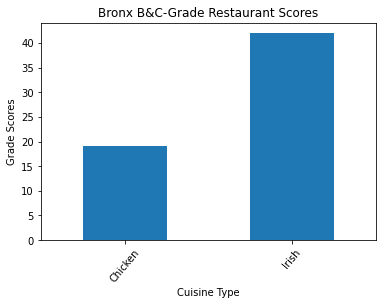

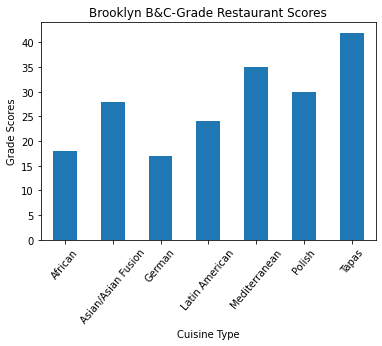

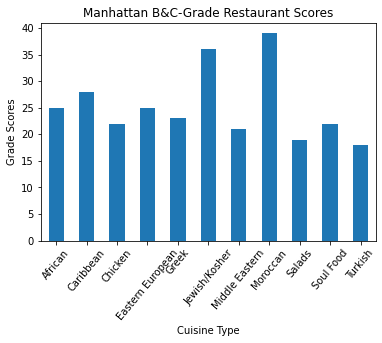

In [20]:
# We need out critical b&c group that has max scores in each borough 
pd.options.display.max_colwidth = 50
for restaurant in three_restaurant_df.index:
    restaurant_info = three_restaurant_df.loc[restaurant]
    critical_split_bc_viol_group[restaurant_info['boro']].plot(kind='bar', title=restaurant_info['boro'] + ' B&C-Grade Restaurant Scores', xlabel='Cuisine Type', ylabel='Grade Scores', rot=50,)
    plt.show()

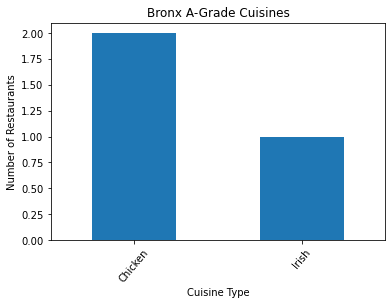

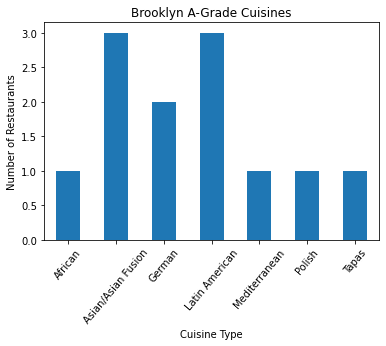

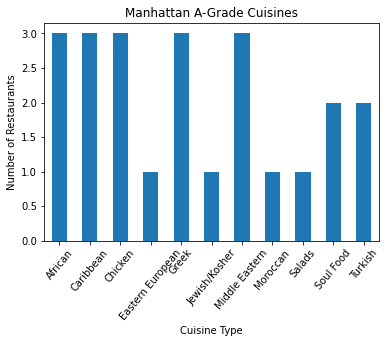

In [15]:
# we need to find the number of A-grade restaurants to graph 
a_viol_info_df_group = abc_viol_info_df.loc[abc_viol_info_df['grade'] == 'A'].groupby(['boro', 'cuisine_description']).dba.count()
for restaurant in three_restaurant_df.index:
    restaurant_info = three_restaurant_df.loc[restaurant]
    a_viol_info_df_group[restaurant_info['boro']].plot(kind='bar', title=restaurant_info['boro'] + ' A-Grade Cuisines', xlabel='Cuisine Type', ylabel='Number of Restaurants', rot=50)
    plt.show()